In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import skimage.io as io
from skimage.feature import hog
from skimage.transform import resize

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load data

In [2]:
DATA_DIR = './dataset/dataset/'
LOGO_DIR = os.path.join(DATA_DIR, 'logos')
LABEL_PATH = os.path.join(DATA_DIR, 'logo_labels.csv')

In [3]:
# image size to pass to HOG Algorithm
HOG_ROWS = 64
HOG_COLS = 128

In [4]:
# set random seed for reproducable
RANDOM_SEED = 1612348362
np.random.seed(seed=RANDOM_SEED)

In [5]:
all_data_df = pd.read_csv(LABEL_PATH, names=['img_path', 'company'], sep='\t')
all_data_df['img_path'] = all_data_df['img_path'].apply(lambda name: os.path.join(LOGO_DIR, name))
all_data_df.head()

,img_path,company
0,./dataset/dataset/logos/logo_0.jpg,viettel
1,./dataset/dataset/logos/logo_1.jpg,viettel
2,./dataset/dataset/logos/logo_2.jpg,viettel
3,./dataset/dataset/logos/logo_3.jpg,viettel
4,./dataset/dataset/logos/logo_4.jpg,viettel


In [6]:
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 2 columns):
img_path    2175 non-null object
company     2175 non-null object
dtypes: object(2)
memory usage: 34.1+ KB


In [7]:
all_data_df.describe()

,img_path,company
count,2175,2175
unique,2175,5
top,./dataset/dataset/logos/logo_1272.jpg,vinamilk
freq,1,510


# Chia dữ liệu thành các tập train/validation/test

Ở đây, nhóm chọn chia dữ liệu train/validation/test theo tỉ lệ 60-20-20

In [8]:
train_val_df, test_df = train_test_split(all_data_df, train_size=0.8, random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=RANDOM_SEED)

Visualize một số sample (và đặc trưng HOG tương ứng sẽ rút trích) trong tập train

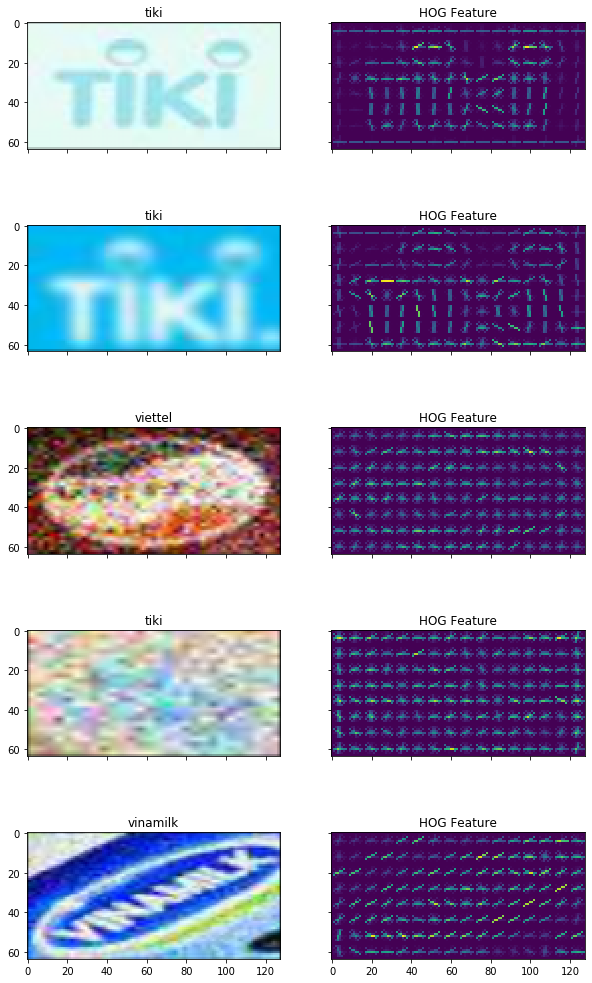

In [9]:
def visualize_some_samples(df, num_samples=5):
    num_samples = min(len(df), num_samples)
    sample_idxs = np.random.choice(len(df), num_samples, replace=False)
    figure, axes = plt.subplots(num_samples, 2, sharex=True, sharey=True, figsize=(10, 18))

    for i, row in enumerate(df.iloc[sample_idxs].itertuples()):
        img = io.imread(row.img_path)
        resized = resize(img, (HOG_ROWS, HOG_COLS, 3), mode='constant')
        _, visualize_img = hog(resized, visualize=True)
        
        axes[i, 0].set_title(row.company)
        axes[i, 0].imshow(resized)
        
        axes[i, 1].set_title('HOG Feature')
        axes[i, 1].imshow(visualize_img)
    plt.show()

visualize_some_samples(train_df, num_samples=5)

In [10]:
class LoadImage(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        img_series = X_df['img_path'].apply(self.load_image)
        return img_series
    
    def load_image(self, img_path: str):
        img = io.imread(img_path)
        return img

In [11]:
class HOGFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, hog_rows=HOG_ROWS, hog_cols=HOG_COLS):
        self.hog_rows = hog_rows
        self.hog_cols = hog_cols
        
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_sr, y=None):
        features = X_sr.apply(self.extract)
        return np.array(features.tolist())
    
    def extract(self, img: np.ndarray):
        img = resize(img, (self.hog_rows, self.hog_cols), mode='constant')
        features = hog(img)
        return features

In [12]:
pipeline = Pipeline([
    ('load_image', LoadImage()),
    ('extract_feature', HOGFeatureExtractor(HOG_ROWS, HOG_COLS)),
    ('normalize', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), solver='lbfgs'))
])

In [ ]:
def find_best(train_df, val_df, pipeline, verbose=True):
    def get_hyperparams():
        learning_rates = [10**i for i in range(-2, 3)]
        weight_decays = [10**i for i in range(-2, 3)]
        hog_sizes = [(64, 128), (96, 198), (32, 64)]
        activations = ['relu', 'logistic']
        
        params = []
        for lr in learning_rates:
            for alpha in weight_decays:
                for hog_size in hog_sizes:
                    for activation in activations:
                        current_params = {
                            'hog_size': hog_size,
                            'activation': activation,
                            'learning_rate': lr,
                            'weight_decay': alpha,
                        }
                        params.append(current_params)
        return params
    
    def get_raw_X_Y(df: pd.DataFrame):
        return df[['img_path']], df['company']
    
    train_raw_X, train_raw_Y = get_raw_X_Y(train_df)
    val_raw_X, val_raw_Y = get_raw_X_Y(val_df)
    
    best_val_accuracy = 0 # range from [0, 1], higher is better
    tried_results = [];
    try_params = get_hyperparams()
    for i, current_params in enumerate(try_params):
        print(f'{i}/{len(try_params)}')
        if verbose:
            print('='*10)
            print(f'Current params: {current_params}')

        pipeline.set_params(
            extract_feature__hog_rows=current_params['hog_size'][0],
            extract_feature__hog_cols=current_params['hog_size'][1],
            classifier__activation=current_params['activation'],
            classifier__alpha=current_params['weight_decay'],
            classifier__learning_rate_init=current_params['learning_rate'],
        )

        pipeline.fit(X=train_raw_X, y=train_raw_Y)
        train_predict = pipeline.predict(X=train_raw_X)
        train_accuracy = accuracy_score(train_raw_Y, train_predict)*100

        val_predict = pipeline.predict(X=val_raw_X)
        val_accuracy = accuracy_score(val_raw_Y, val_predict)*100

        accuracy = {
            'train': train_accuracy,
            'val': val_accuracy,
        }

        result = {'params': current_params, 'accuracy': accuracy}
        tried_results.append(result)

        if verbose:
            print('-'*10)
            print(f'Train accuracy: {train_accuracy:.02f}')
            print(f'Validation accuracy: {val_accuracy:.02f}')
            print('='*10)

        if val_accuracy > best_val_accuracy:
            best_result = result
            best_val_accuracy = val_accuracy

    return best_result, tried_results

best_result, tried_results = find_best(train_df, val_df, pipeline)

0/576
Current params: {'hog_size': (64, 128), 'activation': 'tanh', 'learning_rate': 1e-05, 'weight_decay': 1e-05}
----------
Train accuracy: 100.00
Validation accuracy: 99.08
1/576
Current params: {'hog_size': (64, 128), 'activation': 'relu', 'learning_rate': 1e-05, 'weight_decay': 1e-05}
----------
Train accuracy: 100.00
Validation accuracy: 99.31
2/576
Current params: {'hog_size': (64, 128), 'activation': 'logistic', 'learning_rate': 1e-05, 'weight_decay': 1e-05}
----------
Train accuracy: 100.00
Validation accuracy: 99.31
3/576
Current params: {'hog_size': (96, 198), 'activation': 'tanh', 'learning_rate': 1e-05, 'weight_decay': 1e-05}
----------
Train accuracy: 100.00
Validation accuracy: 98.16
4/576
Current params: {'hog_size': (96, 198), 'activation': 'relu', 'learning_rate': 1e-05, 'weight_decay': 1e-05}
----------
Train accuracy: 100.00
Validation accuracy: 98.85
5/576
Current params: {'hog_size': (96, 198), 'activation': 'logistic', 'learning_rate': 1e-05, 'weight_decay': 1e-0

# Test

In [13]:
# best_params = best_result['params']
best_params = {'hog_size': (64, 128), 'activation': 'logistic', 'learning_rate': 1e-05, 'weight_decay': 1e-05}
pipeline.set_params(
    extract_feature__hog_rows=best_params['hog_size'][0],
    extract_feature__hog_cols=best_params['hog_size'][1],
    classifier__activation=best_params['activation'],
    classifier__alpha=best_params['weight_decay'],
    classifier__learning_rate_init=best_params['learning_rate'],
)

Pipeline(memory=None,
         steps=[('load_image', LoadImage()),
                ('extract_feature',
                 HOGFeatureExtractor(hog_cols=128, hog_rows=64)),
                ('normalize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 MLPClassifier(activation='logistic', alpha=1e-05,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=1e-05, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=0.1,

In [15]:
pipeline.fit(train_val_df[['img_path']], train_val_df['company'])

Pipeline(memory=None,
         steps=[('load_image', LoadImage()),
                ('extract_feature',
                 HOGFeatureExtractor(hog_cols=128, hog_rows=64)),
                ('normalize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 MLPClassifier(activation='logistic', alpha=1e-05,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=1e-05, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=0.1,

In [17]:
test_predict = pipeline.predict(test_df[['img_path']])

In [18]:
accuracy_score(test_df['company'], test_predict)*100

99.08045977011494